In [1]:
# %%
from UserClass import *
from UCB1_Learner import *
from Non_Stationary_Environment import *
from SWUCB_Learner import *
from CDUCB_Learner import *
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt

n_arms = 5
c1 = UserClass(
    np.array([10, 20, 30, 40, 50]),
    np.array([[0.95, 0.82, 0.53, 0.28, 0.14], [0.95, 0.64, 0.96, 0.08, 0.14], [0.05, 0.64, 0.96, 0.08, 0.64]])
)
prb = (c1.prices - 8) * c1.probabilities
prb = prb / np.sqrt(np.sum(prb ** 2))

T = 365
n_phases = 3
phases_len = int(T / n_phases)
n_experiments = 100
M = 50
eps = 0.15
h = 2 * np.log(T)
alpha = np.sqrt(0.5 * np.log(T) / T)

ucb1_rewards_per_experiment = []
swucb_w1_rewards_per_experiment = []
swucb_w2_rewards_per_experiment = []
swucb_w3_rewards_per_experiment = []
cducb_rewards_per_experiment = []

for e in range(0, n_experiments):
    ucb1_env = Non_Stationary_Environment(prb, T, n_phases)
    swucb_w1_env = Non_Stationary_Environment(prb, T, n_phases)
    swucb_w2_env = Non_Stationary_Environment(prb, T, n_phases)
    swucb_w3_env = Non_Stationary_Environment(prb, T, n_phases)
    cducb_env = Non_Stationary_Environment(prb, T, n_phases)

    ucb1_learner = UCB1_Learner(n_arms)
    swucb_learner_w1 = SWUCB_Learner(n_arms, int(T // 2))
    swucb_learner_w2 = SWUCB_Learner(n_arms, int(sqrt(T)))
    swucb_learner_w3 = SWUCB_Learner(n_arms, int(2 * sqrt(T)))
    cducb_learner = CDUCB_Learner(n_arms, M, eps, h, alpha)

    for t in range(0, T):
        # UCB1
        pulled_arm = ucb1_learner.pull_arm()
        reward = ucb1_env.round(pulled_arm)
        ucb1_learner.update(pulled_arm, reward)

        # UCB1 window size = T
        pulled_arm = swucb_learner_w1.pull_arm()
        reward = swucb_w1_env.round(pulled_arm)
        swucb_learner_w1.update(pulled_arm, reward)

        # UCB1 window size = sqrt(T)
        pulled_arm = swucb_learner_w2.pull_arm()        
        reward = swucb_w2_env.round(pulled_arm)
        swucb_learner_w2.update(pulled_arm, reward)

        # UCB1 window size = 2 * sqrt(T)
        pulled_arm = swucb_learner_w3.pull_arm()
        reward = swucb_w3_env.round(pulled_arm)
        swucb_learner_w3.update(pulled_arm, reward)

        # CUSUM UCB
        pulled_arm = cducb_learner.pull_arm()
        reward = cducb_env.round(pulled_arm)
        cducb_learner.update(pulled_arm, reward)

    ucb1_rewards_per_experiment.append(ucb1_learner.collected_rewards)
    swucb_w1_rewards_per_experiment.append(swucb_learner_w1.collected_rewards)
    swucb_w2_rewards_per_experiment.append(swucb_learner_w2.collected_rewards)
    swucb_w3_rewards_per_experiment.append(swucb_learner_w3.collected_rewards)
    cducb_rewards_per_experiment.append(cducb_learner.collected_rewards)

ucb1_rewards_per_experiment = np.array(ucb1_rewards_per_experiment)
swucb_w1_rewards_per_experiment = np.array(swucb_w1_rewards_per_experiment)
swucb_w2_rewards_per_experiment = np.array(swucb_w2_rewards_per_experiment)
swucb_w3_rewards_per_experiment = np.array(swucb_w3_rewards_per_experiment)
cducb_rewards_per_experiment = np.array(cducb_rewards_per_experiment)

ucb1_regret = np.zeros(T)
swucb_w1_regret = np.zeros(T)
swucb_w2_regret = np.zeros(T)
swucb_w3_regret = np.zeros(T)
cducb_regret = np.zeros(T)

ucb1_instantaneous_regret = np.zeros(T)
swucb_w1_instantaneous_regret = np.zeros(T)
swucb_w2_instantaneous_regret = np.zeros(T)
swucb_w3_instantaneous_regret = np.zeros(T)
cducb_instantaneous_regret = np.zeros(T)

opt_per_phase = prb.max(axis=1)
optimum_per_round = np.zeros(T)

for i in range(n_phases):
    t_index = range(i * phases_len, (i + 1) * phases_len)
    optimum_per_round[t_index] = opt_per_phase[i]

    # Regret
    ucb1_regret[t_index] = np.mean(opt_per_phase[i] - ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w3_rewards_per_experiment, axis=0)[t_index]
    cducb_regret[t_index] = np.mean(opt_per_phase[i] - cducb_rewards_per_experiment, axis=0)[t_index]

    # Instantaneous regret
    ucb1_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(swucb_w3_rewards_per_experiment, axis=0)[t_index]
    cducb_instantaneous_regret[t_index] = opt_per_phase[i] - np.mean(cducb_rewards_per_experiment, axis=0)[t_index]

ucb1_label = "Stationary UCB1"
swucb_w1_label = r"$SW\ UCB1,\ window\ size=\frac{T}{2}$"
swucb_w2_label = r"$SW\ UCB1,\ window\ size=\sqrt{T}$"
swucb_w3_label = r"$SW\ UCB1,\ window\ size=2 \sqrt{T}$"
cducb_label = "CUSUM UCB1"

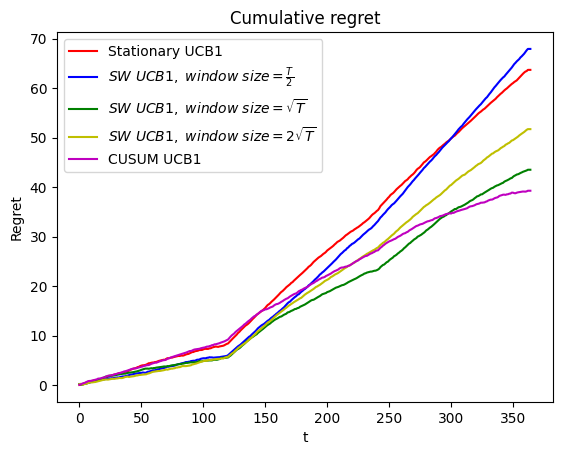

In [2]:
# %%
# Cumulative regret
plt.figure("Cumulative regret")
plt.title("Cumulative regret")
plt.xlabel('t')
plt.ylabel('Regret')
plt.plot(np.cumsum(ucb1_regret), 'r', label=ucb1_label)
plt.plot(np.cumsum(swucb_w1_regret), 'b', label=swucb_w1_label)
plt.plot(np.cumsum(swucb_w2_regret), 'g', label=swucb_w2_label)
plt.plot(np.cumsum(swucb_w3_regret), 'y', label=swucb_w3_label)
plt.plot(np.cumsum(cducb_regret), 'm', label=cducb_label)
plt.legend(loc=0)
plt.show()

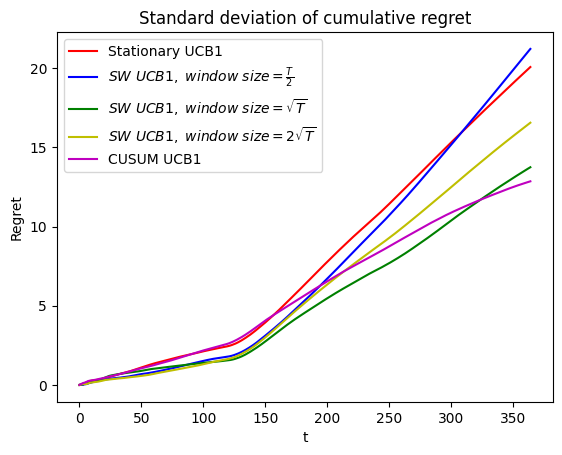

In [3]:
# %%
# Standard deviation of cumulative regret
stducb = [(np.cumsum(ucb1_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w1 = [(np.cumsum(swucb_w1_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w2 = [(np.cumsum(swucb_w2_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w3 = [(np.cumsum(swucb_w3_regret))[:i].std() for i in range(1, T + 1)]
stdcducb = [(np.cumsum(cducb_regret))[:i].std() for i in range(1, T + 1)]

plt.figure("Standard deviation of cumulative regret")
plt.title("Standard deviation of cumulative regret")
plt.xlabel('t')
plt.ylabel('Regret')
plt.plot(stducb, 'r', label=ucb1_label)
plt.plot(stdswucb_w1, 'b', label=swucb_w1_label)
plt.plot(stdswucb_w2, 'g', label=swucb_w2_label)
plt.plot(stdswucb_w3, 'y', label=swucb_w3_label)
plt.plot(stdcducb, 'm', label=cducb_label)
plt.legend(loc=0)
plt.show()

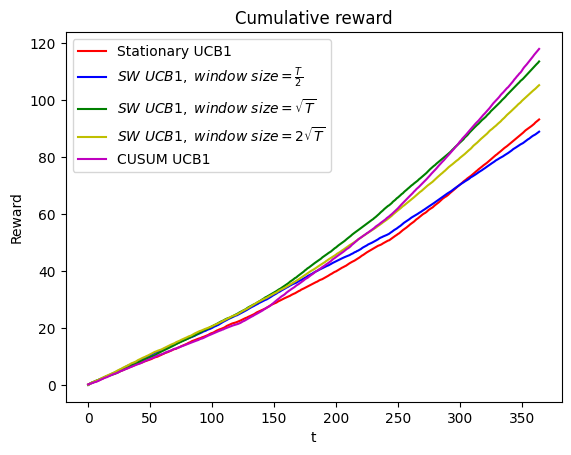

In [4]:
# %%
# Cumulative reward
plt.figure("Cumulative reward")
plt.title("Cumulative reward")
plt.xlabel('t')
plt.ylabel('Reward')
plt.plot(np.cumsum(np.mean(ucb1_rewards_per_experiment, axis=0)), 'r', label=ucb1_label)
plt.plot(np.cumsum(np.mean(swucb_w1_rewards_per_experiment, axis=0)), 'b', label=swucb_w1_label)
plt.plot(np.cumsum(np.mean(swucb_w2_rewards_per_experiment, axis=0)), 'g', label=swucb_w2_label)
plt.plot(np.cumsum(np.mean(swucb_w3_rewards_per_experiment, axis=0)), 'y', label=swucb_w3_label)
plt.plot(np.cumsum(np.mean(cducb_rewards_per_experiment, axis=0)), 'm', label=cducb_label)
plt.legend(loc=0)
plt.show()

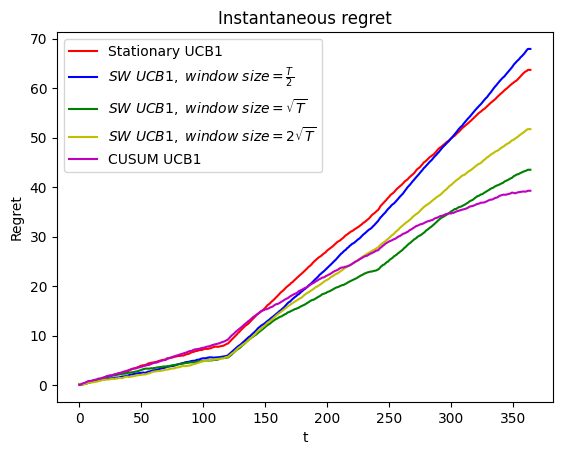

In [5]:
# %%
# Instantaneous regret
plt.figure("Instantaneous regret")
plt.title("Instantaneous regret")
plt.xlabel('t')
plt.ylabel('Regret')
plt.plot(np.cumsum(ucb1_instantaneous_regret), 'r', label=ucb1_label)
plt.plot(np.cumsum(swucb_w1_instantaneous_regret), 'b', label=swucb_w1_label)
plt.plot(np.cumsum(swucb_w2_instantaneous_regret), 'g', label=swucb_w2_label)
plt.plot(np.cumsum(swucb_w3_instantaneous_regret), 'y', label=swucb_w3_label)
plt.plot(np.cumsum(cducb_instantaneous_regret), 'm', label=cducb_label)
plt.legend(loc=0)
plt.show()

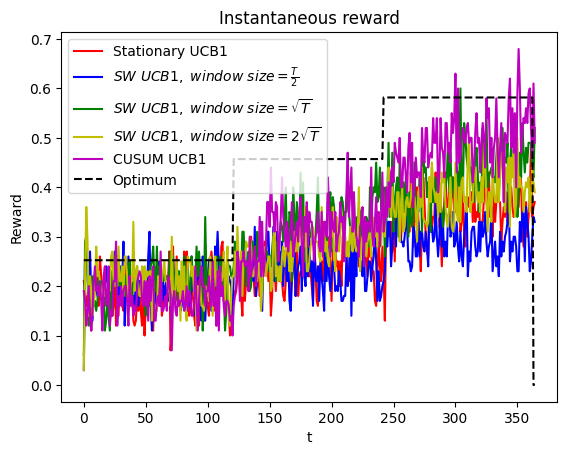

In [6]:
# %%
# Instantaneous reward
plt.figure("Instantaneous reward")
plt.title("Instantaneous reward")
plt.xlabel('t')
plt.ylabel('Reward')
plt.plot(np.mean(ucb1_rewards_per_experiment, axis=0), 'r', label=ucb1_label)
plt.plot(np.mean(swucb_w1_rewards_per_experiment, axis=0), 'b', label=swucb_w1_label)
plt.plot(np.mean(swucb_w2_rewards_per_experiment, axis=0), 'g', label=swucb_w2_label)
plt.plot(np.mean(swucb_w3_rewards_per_experiment, axis=0), 'y', label=swucb_w3_label)
plt.plot(np.mean(cducb_rewards_per_experiment, axis=0), 'm', label=cducb_label)
plt.plot(optimum_per_round, 'k--', label="Optimum")
plt.legend(loc=0)
plt.show()